In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import pickle

/home/tonca/.local/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
df_tags = pd.read_hdf("data/dataset_qustions_test.h5", key="tags")


multilabel_binarizer = MultiLabelBinarizer(sparse_output=True)
multilabel_binarizer.fit(df_tags)
Y = multilabel_binarizer.transform(df_tags)

Y.shape

(452421, 26189)

In [3]:
Y.sum(axis=0).shape

(1, 26189)

In [4]:
df_tags

0         [php, image-processing, file-upload, upload, m...
1                                                 [firefox]
2                             [r, matlab, machine-learning]
3                                       [c#, url, encoding]
4                             [php, api, file-get-contents]
5                            [c#, asp.net, windows-phone-7]
6                       [.net, javascript, code-generation]
7            [sql, variables, parameters, procedure, calls]
8                            [.net, obfuscation, reflector]
9                    [algorithm, language-agnostic, random]
10                                              [windows-7]
11                          [php, url-routing, conventions]
12                                     [r, temporary-files]
13                                           [wpf, binding]
14        [javascript, code-generation, playframework, m...
15        [php, xml, hash, multidimensional-array, simpl...
16                                      

In [5]:
X_embeddings = np.load("data/dataset_embeddings_test.npy")
X_embeddings

array([[ 0.34232768,  1.337227  ,  1.7082647 , ...,  1.6539072 ,
        -1.196736  , -1.3125612 ],
       [ 1.897243  ,  0.7641299 ,  1.2434    , ..., -0.00939726,
        -0.5859856 , -1.0307999 ],
       [-2.760528  , -4.8726983 , -4.3410645 , ..., -0.95044076,
         1.2555007 , -3.3224008 ],
       ...,
       [-1.3603874 ,  1.0089053 ,  0.4866524 , ...,  0.29693303,
        -0.6223885 , -0.84951264],
       [ 0.3001286 ,  1.4637185 ,  1.7441342 , ...,  0.8536412 ,
        -1.0658534 , -0.76843125],
       [-0.98591256,  2.8738854 ,  0.9802149 , ...,  1.2585107 ,
        -0.48105246, -3.6591394 ]], dtype=float32)

In [6]:
top_tags = np.array(Y.sum(axis=0).argsort())[0,-100:]
mask = np.array(Y[:,top_tags].sum(axis=1)>0)[:,0]

In [7]:
Y_top = Y[:,top_tags]

## Try with Doc2Vec embeddings

In [8]:
X_embeddings.shape

(452421, 20)

In [9]:
ros = RandomUnderSampler(random_state=9000)
X_resampled, Y_resampled = ros.fit_sample(X_embeddings, Y_top)

In [10]:
X_tr, X_te, Y_tr, Y_te = train_test_split(X_resampled, Y_resampled, test_size=0.2, random_state=9000)

In [11]:
np.save("data/Ytr.npy",Y_tr)
np.save("data/Yte.npy",Y_te)
np.save("data/Xtr.npy",X_tr)
np.save("data/Xte.npy",X_te)

In [12]:
X_tr.shape

(108160, 20)

In [13]:
Y_tr.shape

(108160, 100)

In [14]:
Y_resampled.shape

(135200, 100)

In [15]:
Y_tr.shape

(108160, 100)

Text(0.5, 1.0, 'class distribution in training set after resampling')

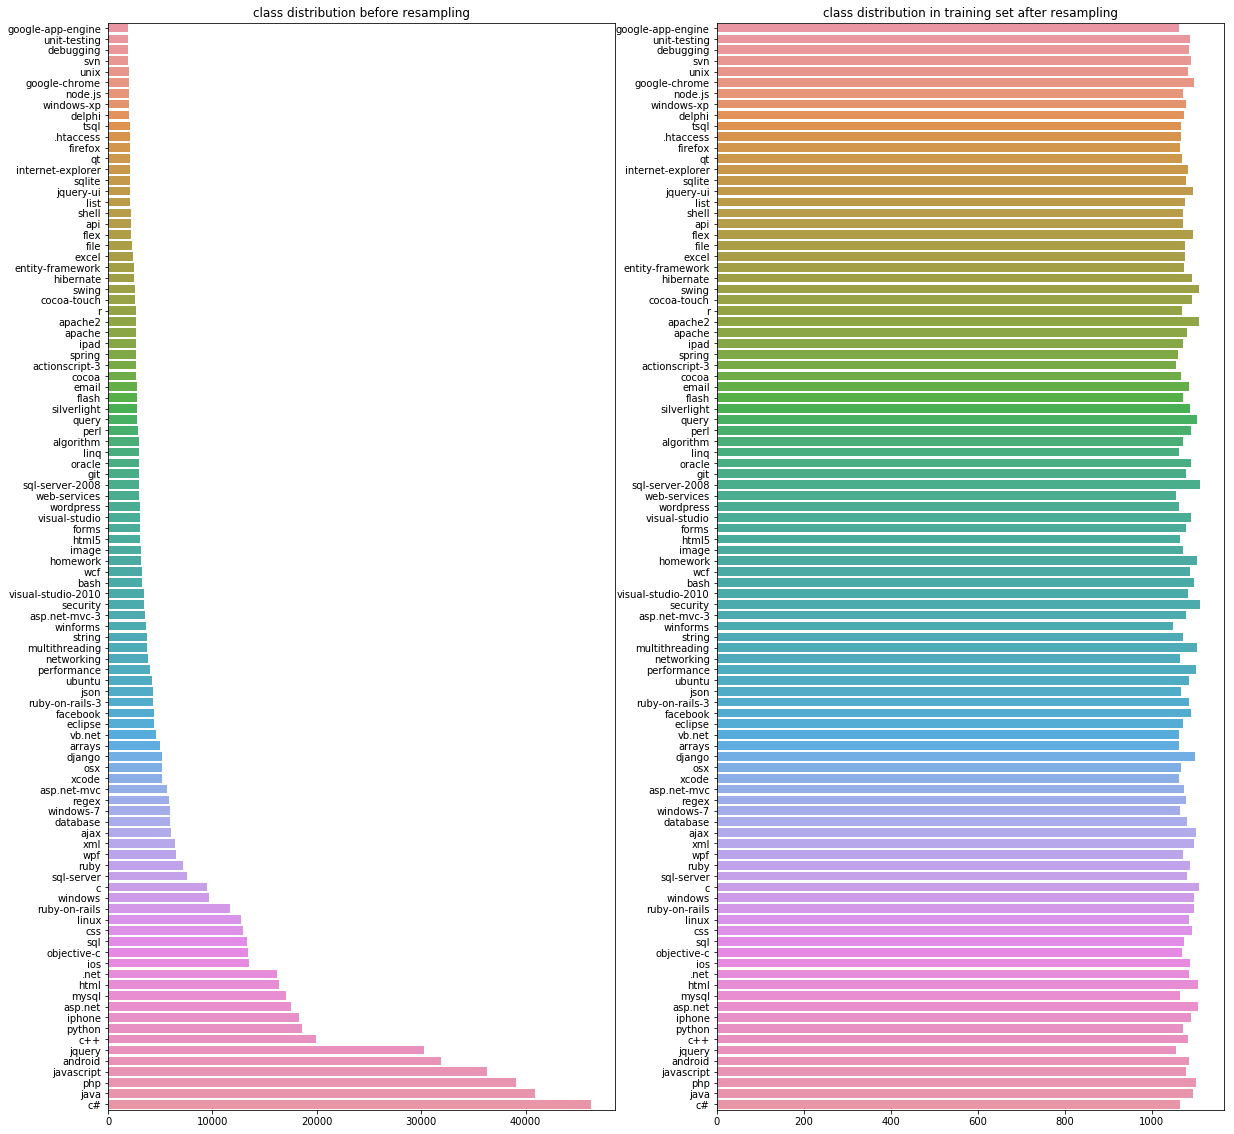

In [16]:
fig = plt.figure(figsize=(20,20))
(ax_test, ax_train) = fig.subplots(ncols=2, nrows=1)
g1 = sns.barplot(x=np.array(Y_top.sum(axis=0)).squeeze(), y=multilabel_binarizer.classes_[top_tags], ax=ax_test)
g2 = sns.barplot(x=np.array(Y_tr.sum(axis=0)).squeeze(), y=multilabel_binarizer.classes_[top_tags], ax=ax_train)
g1.set_title("class distribution before resampling")
g2.set_title("class distribution in training set after resampling")

In [44]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix

def print_score(y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    print("Accuracy: {}".format(accuracy_score(Y_te, y_pred)))
    print("Balanced Accuracy: {}".format(balanced_accuracy_score(np.argmax(Y_te, axis=1), np.argmax(y_pred, axis=1))))
    print("F1 score: {}".format(f1_score(Y_te, y_pred, average="micro")))
    print("---")

In [18]:
knn = KNeighborsClassifier()

%time knn.fit(X_tr, Y_tr)

CPU times: user 1.53 s, sys: 406 ms, total: 1.94 s
Wall time: 1.99 s


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [19]:
%time y_pred = knn.predict(X_te)
print_score(y_pred, knn)

CPU times: user 7min 45s, sys: 1.14 s, total: 7min 46s
Wall time: 7min 56s
Clf:  KNeighborsClassifier
Accuracy: 0.12252218934911242
Balanced Accuracy: 0.1310801109004881
F1 score: 0.19912249068397644
---


In [39]:
sgd = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=6, tol=None)

clf = OneVsRestClassifier(sgd)
%time clf.fit(X_tr, Y_tr)

CPU times: user 1min 37s, sys: 36.5 s, total: 2min 14s
Wall time: 1min 17s


OneVsRestClassifier(estimator=SGDClassifier(alpha=0.001, average=False,
                                            class_weight=None,
                                            early_stopping=False, epsilon=0.1,
                                            eta0=0.0, fit_intercept=True,
                                            l1_ratio=0.15,
                                            learning_rate='optimal',
                                            loss='hinge', max_iter=6,
                                            n_iter_no_change=5, n_jobs=None,
                                            penalty='l2', power_t=0.5,
                                            random_state=42, shuffle=True,
                                            tol=None, validation_fraction=0.1,
                                            verbose=0, warm_start=False),
                    n_jobs=None)

In [40]:
%time y_pred = clf.predict(X_te)
print_score(y_pred, sgd)

CPU times: user 1.41 s, sys: 15.6 ms, total: 1.42 s
Wall time: 1.43 s
Clf:  SGDClassifier
Accuracy: 0.004326923076923077
Balanced Accuracy: 0.014408986906913475
F1 score: 0.00868573111037503
---


In [22]:
lr = LogisticRegression(solver="lbfgs")

clf = OneVsRestClassifier(lr)
%time clf.fit(X_tr, Y_tr)

CPU times: user 3min 35s, sys: 1min 49s, total: 5min 25s
Wall time: 1min 33s


OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [23]:
%time y_pred = clf.predict(X_te)
print_score(y_pred, lr)

CPU times: user 625 ms, sys: 203 ms, total: 828 ms
Wall time: 297 ms
Clf:  LogisticRegression
Accuracy: 0.03835059171597633
Balanced Accuracy: 0.05603249818460283
F1 score: 0.0993566833452466
---


## Try with tf-idf

In [24]:
df_questions = pd.read_hdf("data/dataset_questions_test.h5", key="data")

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(df_questions.text)

tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)

In [26]:
ros = RandomUnderSampler(random_state=9000)
X_resampled, Y_resampled = ros.fit_sample(X_tfidf, Y_top)

In [27]:
X_tr, X_te, Y_tr, Y_te = train_test_split(X_resampled, Y_resampled, test_size=0.2, random_state=9000)

In [28]:
X_tr.shape

(108160, 1247961)

In [29]:
pickle.dump(Y_tr, open("data/Ytfidf_tr.pkl","wb"), pickle.HIGHEST_PROTOCOL)
pickle.dump(Y_te, open("data/Ytfidf_te.pkl","wb"), pickle.HIGHEST_PROTOCOL)
pickle.dump(X_tr, open("data/Xtfidf_tr.pkl","wb"), pickle.HIGHEST_PROTOCOL)
pickle.dump(X_te, open("data/Xtfidf_te.pkl","wb"), pickle.HIGHEST_PROTOCOL)

Text(0.5, 1.0, 'class distribution in training set after resampling')

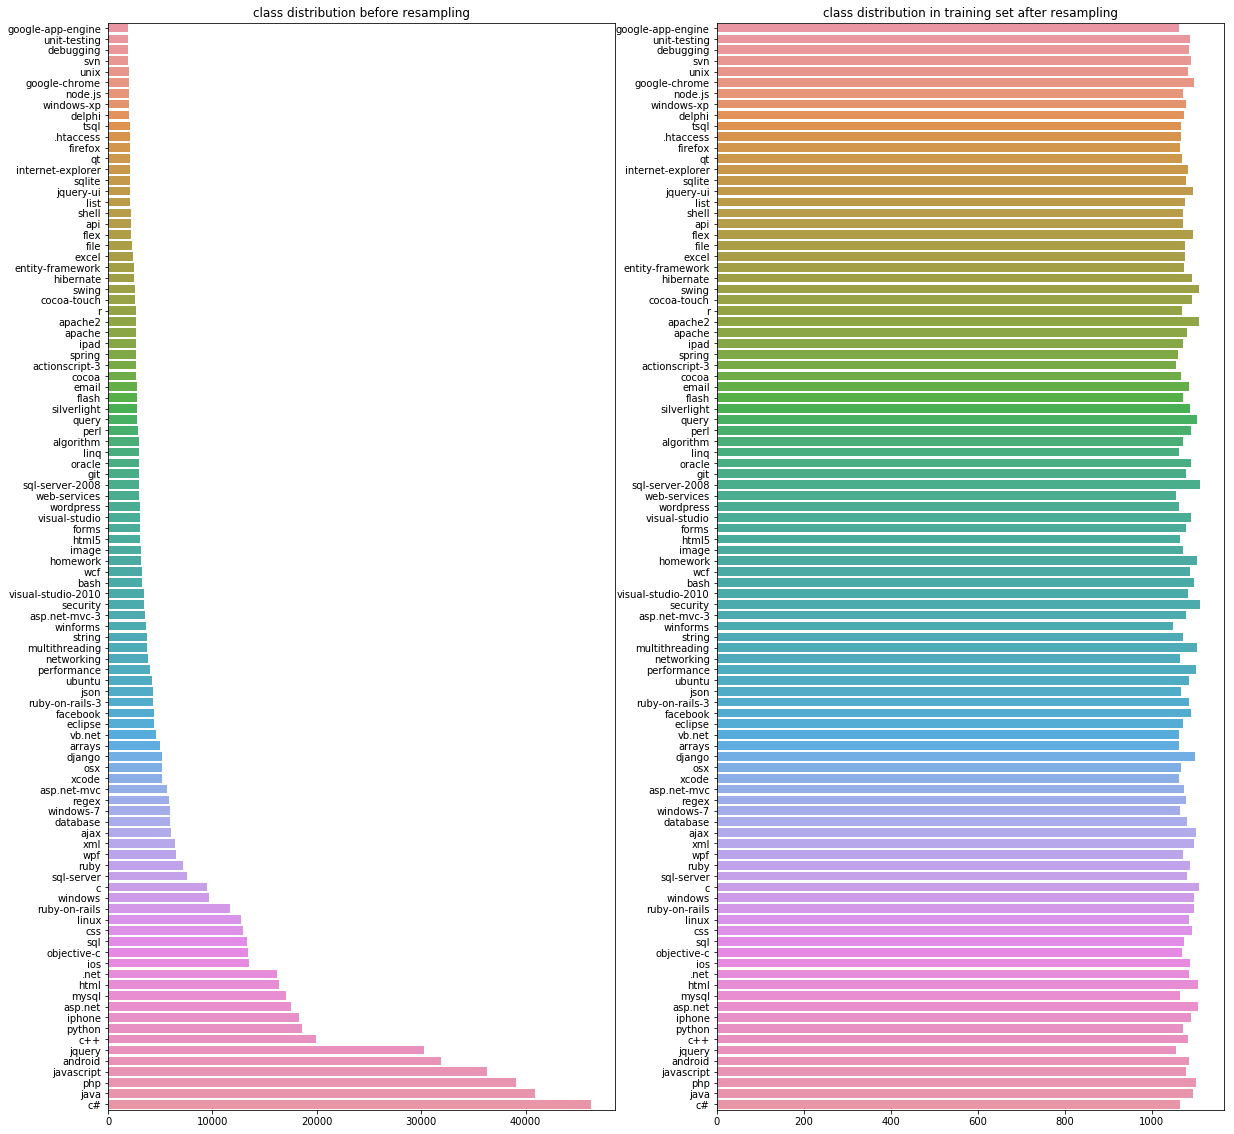

In [30]:
fig = plt.figure(figsize=(20,20))
(ax_test, ax_train) = fig.subplots(ncols=2, nrows=1)
g1 = sns.barplot(x=np.array(Y_top.sum(axis=0)).squeeze(), y=multilabel_binarizer.classes_[top_tags], ax=ax_test)
g2 = sns.barplot(x=np.array(Y_tr.sum(axis=0)).squeeze(), y=multilabel_binarizer.classes_[top_tags], ax=ax_train)
g1.set_title("class distribution before resampling")
g2.set_title("class distribution in training set after resampling")

In [31]:
knn = KNeighborsClassifier()

%time knn.fit(X_tr, Y_tr)

CPU times: user 1.09 s, sys: 625 ms, total: 1.72 s
Wall time: 1.77 s


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [32]:
%time y_pred = knn.predict(X_te)
print_score(y_pred, knn)

CPU times: user 9min 20s, sys: 3min 4s, total: 12min 24s
Wall time: 12min 51s
Clf:  KNeighborsClassifier
Accuracy: 0.2106508875739645
Balanced Accuracy: 0.21457292961052535
F1 score: 0.31861278142917077
---


In [37]:
sgd = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, n_jobs=4)

clf = OneVsRestClassifier(sgd)
%time clf.fit(X_tr, Y_tr)

CPU times: user 1min 39s, sys: 37.8 s, total: 2min 16s
Wall time: 1min 17s


OneVsRestClassifier(estimator=SGDClassifier(alpha=0.001, average=False,
                                            class_weight=None,
                                            early_stopping=False, epsilon=0.1,
                                            eta0=0.0, fit_intercept=True,
                                            l1_ratio=0.15,
                                            learning_rate='optimal',
                                            loss='hinge', max_iter=1000,
                                            n_iter_no_change=5, n_jobs=4,
                                            penalty='l2', power_t=0.5,
                                            random_state=None, shuffle=True,
                                            tol=0.001, validation_fraction=0.1,
                                            verbose=0, warm_start=False),
                    n_jobs=None)

In [38]:
%time y_pred = clf.predict(X_te)
print_score(y_pred, sgd)

CPU times: user 1.36 s, sys: 46.9 ms, total: 1.41 s
Wall time: 1.36 s
Clf:  SGDClassifier
Accuracy: 0.004326923076923077
Balanced Accuracy: 0.014408986906913475
F1 score: 0.00868573111037503
---


In [41]:
lr = LogisticRegression(solver="lbfgs")

clf = OneVsRestClassifier(lr)
%time clf.fit(X_tr, Y_tr)

CPU times: user 1h 26min 31s, sys: 48min 49s, total: 2h 15min 21s
Wall time: 45min 25s


OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [42]:
%time y_pred = clf.predict(X_te)
print_score(y_pred, lr)

CPU times: user 1.03 s, sys: 15.6 ms, total: 1.05 s
Wall time: 1.03 s
Clf:  LogisticRegression
Accuracy: 0.22555473372781065
Balanced Accuracy: 0.24431997837306935
F1 score: 0.3707198631459868
---


In [50]:
cm = confusion_matrix(np.argmax(Y_te, axis=1), np.argmax(y_pred, axis=1))

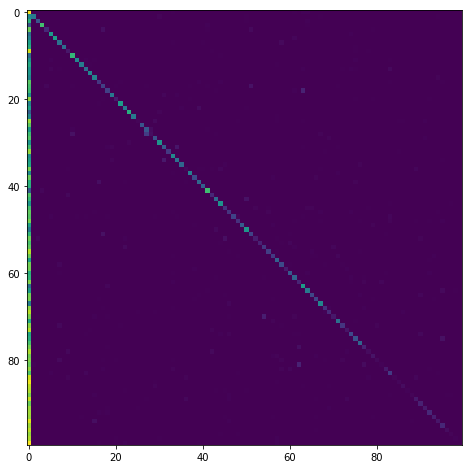

In [51]:
plt.figure(figsize=(8,8))
plt.imshow(cm)